# Overview

This notebook provides an overview of how to process documents using textract and third party tools.  

In [1]:
# imports libraries 
import boto3
import time

In [30]:
# define services
textract = boto3.client('textract')
s3 = boto3.resource('s3')

In [31]:
bucket_name = 'random.datasets.sengstacken'
bucket = s3.Bucket(bucket_name)

# asynchronous operations

Below is an overview of the flow for asynchronous processing.  I don't like messing with SNS and SQS for this, so instead we'll call API to check job completion.

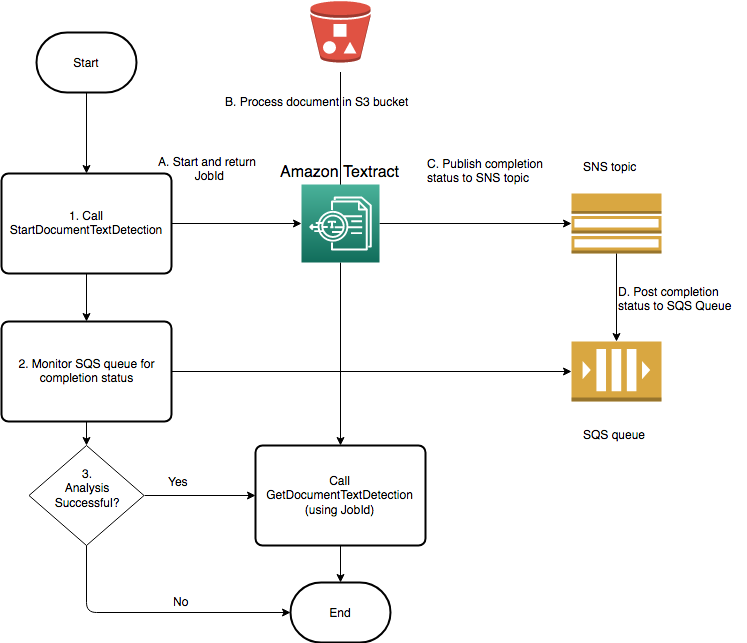

In [43]:
def startJob(s3BucketName, objectName):
    response = None
    client = boto3.client('textract')
    response = client.start_document_text_detection(
    DocumentLocation={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': objectName
        }
    })

    return response["JobId"]

def isJobComplete(jobId):
    time.sleep(5)
    client = boto3.client('textract')
    response = client.get_document_text_detection(JobId=jobId)
    status = response["JobStatus"]
    print("Job status: {}".format(status))

    while(status == "IN_PROGRESS"):
        time.sleep(10)
        response = client.get_document_text_detection(JobId=jobId)
        status = response["JobStatus"]
        print("Job status: {}".format(status))

    return status

def getJobResults(jobId):

    pages = []
    time.sleep(5)
    client = boto3.client('textract')
    response = client.get_document_text_detection(JobId=jobId)
    
    pages.append(response)
    print("Resultset page recieved: {}".format(len(pages)))
    nextToken = None
    if('NextToken' in response):
        nextToken = response['NextToken']

    while(nextToken):
        time.sleep(1)

        response = client.get_document_text_detection(JobId=jobId, NextToken=nextToken)

        pages.append(response)
        print("Resultset page recieved: {}".format(len(pages)))
        nextToken = None
        if('NextToken' in response):
            nextToken = response['NextToken']

    return pages

In [44]:
%%time

# Document
s3BucketName = "random.datasets.sengstacken"
documentName = "textract/2003ltr.pdf"

jobId = startJob(s3BucketName, documentName)
print("Started job with id: {}".format(jobId))

if(isJobComplete(jobId)):
    response = getJobResults(jobId)

Started job with id: 72b8b4807af58e8a5bdcc7a185ee20c289053c6dff3996456a2fa98a60c7b2d1
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: SUCCEEDED
Resultset page recieved: 1
Resultset page recieved: 2
Resultset page recieved: 3
Resultset page recieved: 4
Resultset page recieved: 5
Resultset page recieved: 6
Resultset page recieved: 7
Resultset page recieved: 8
Resultset page recieved: 9
Resultset page recieved: 10
Resultset page recieved: 11
Resultset page recieved: 12
Resultset page recieved: 13
Resultset page recieved: 14
Resultset page recieved: 15
CPU times: user 2 s, sys: 8.95 ms, total: 2.01 s
Wall time: 59.8 s


In [36]:
len(response)  # one entry for each page

15

Now let's grab the raw text from one of those pages

In [41]:

page = response[2]
raw_text = []
for block in page['Blocks']:
    if block['BlockType'] != 'PAGE':
        raw_text.append(block['Text'])
        
print(' '.join(raw_text))

in but not as painful as doing something stupid. (I speak from experience.) Overall, we are certain Berkshire's performance in the future will fall far short of what it has been in the past. Nonetheless, Charlie and I remain hopeful that we can deliver results that are modestly above average. That's what we're being paid for. Acquisitions As regular readers know, our acquisitions have often come about in strange ways. None, however, had a more unusual genesis than our purchase last year of Clayton Homes. The unlikely source was a group of finance students from the University of Tennessee, and their teacher, Dr. Al Auxier. For the past five years, Al has brought his class to Omaha, where the group tours Nebraska Furniture Mart and Borsheim's, eats at Gorat's and then comes to Kiewit Plaza for a session with me. Usually about 40 students participate. After two hours of give-and-take, the group traditionally presents me with a thank-you gift. (The doors stay locked until they do.) In past

# synchronous operations
Note that you can only use .png and .jpg files for synchronous operations - PDF is not supported :(

In [42]:
for obj in bucket.objects.filter(Prefix='textract/'):

    # use textract to process s3 file
    if obj.key.split('.')[-1] in ['jpg','jpeg','png']:  # note pdf is not supported in .detect_document_text
        print('{0}:{1}'.format(bucket.name, obj.key))
        print()
        response = textract.detect_document_text(
                Document={'S3Object': {'Bucket': bucket_name, 'Name': obj.key}}
        )

        #print(response)
        for block in response['Blocks']:
            if block['BlockType'] != 'PAGE':
                print('DETECTED: ' + block['Text'] + ' -- CONF: ' + "{:.2f}".format(block['Confidence']) + "%")
        
        

random.datasets.sengstacken:textract/employmentapp.png
()
DETECTED: Employment Application -- CONF: 99.95%
DETECTED: Applicant Information -- CONF: 99.89%
DETECTED: Full Name: Jane Doe -- CONF: 99.89%
DETECTED: Phone Number: 555-0100 -- CONF: 99.71%
DETECTED: Home Address: 123 Any Street, Any Town, USA -- CONF: 99.68%
DETECTED: Mailing Address: same as home address -- CONF: 99.78%
DETECTED: Previous Employment History -- CONF: 97.14%
DETECTED: Start Date -- CONF: 99.89%
DETECTED: End Date -- CONF: 99.90%
DETECTED: Employer Name -- CONF: 99.94%
DETECTED: Position Held -- CONF: 99.91%
DETECTED: Reason for leaving -- CONF: 99.95%
DETECTED: 1/15/2009 -- CONF: 99.89%
DETECTED: 6/30/2011 -- CONF: 99.13%
DETECTED: Any Company -- CONF: 99.94%
DETECTED: Assistant Baker -- CONF: 99.96%
DETECTED: Family relocated -- CONF: 99.95%
DETECTED: 7/1/2011 -- CONF: 99.94%
DETECTED: 8/10/2013 -- CONF: 99.93%
DETECTED: Best Corp. -- CONF: 99.89%
DETECTED: Baker -- CONF: 99.94%
DETECTED: Better opportunity -

# Word Docs
Here we will use a 3rd party library to process the word docs

In [2]:
filename = 'Project Triumvirate - DRAFT.docx'

### Docx2txt

In [3]:
!pip install docx2txt 

  Using cached docx2txt-0.8.tar.gz (2.8 kB)
  Created wheel for docx2txt: filename=docx2txt-0.8-py3-none-any.whl size=3963 sha256=c2e86eac9ac7aaacce96ae4aa97740efa840b3019f8245a595aec35f3e5b3dd4
  Stored in directory: /home/ec2-user/.cache/pip/wheels/66/d7/77/4dc0e151e2ef19b5474722fd943e312603f10016baab494f7a
Successfully built docx2txt
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
import docx2txt

In [5]:
# extract text
text = docx2txt.process(filename)

In [6]:
text

'Objective: Using the Federal Civilian submarket as our proof of concept (PoC), we take a data driven approach to propose integrated solutions to three common WWPS problems that block growth in adoption of AWS services. They are (1) the impact of the non-builder persona on security service adoption, (2) effectively prioritizing solution development and investment decisions, and (3) aligning market drivers that impact customer decision making with AWS services, specialty\\specialist teams and sales and technical account plans (TAP’S).  Triumvirate will enhance and integrate existing building blocks in AWS, namely the AWS Solutions Page, the Rubiks project and the new TAP’s. Upon successful PoC, we expand the mechanisms to other customer verticals (DoD, FedFin, EDU, SLG, etc) and other services managed by specialty sales teams. \n\n\n\nAWS Solutions Page (Steve Morads WWCS Solutions Team) are vetted, well architected, and supported technical reference implementations designed to help cus

### docx2python

In [8]:
!pip install docx2python

  Using cached docx2python-1.24-py3-none-any.whl (22 kB)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [9]:
from docx2python import docx2python

In [20]:
# extract docx content, ignore images
doc_out = docx2python(filename)

In [22]:
doc_out.text

'Objective: Using the Federal Civilian submarket as our proof of concept (PoC), we take a data driven approach to propose integrated solutions to three common WWPS problems that block growth in adoption of AWS services. They are (1) the impact of the non-builder persona on security service adoption, (2) effectively prioritizing solution development and investment decisions, and (3) aligning market drivers that impact customer decision making with AWS services, specialty\\specialist teams and sales and technical account plans (TAP’S).  Triumvirate will enhance and integrate existing building blocks in AWS, namely the AWS Solutions Page, the Rubiks project and the new TAP’s. Upon successful PoC, we expand the mechanisms to other customer verticals (DoD, FedFin, EDU, SLG, etc) and other services managed by specialty sales teams. \n\n\n\n<a href="https://aws.amazon.com/solutions/">AWS Solutions Page</a> (Steve Morads WWCS Solutions Team) are vetted, well architected, and supported technica